In [1]:
import os
import random
import pandas as pd
import re
import src.constants
import os
import requests
import pandas as pd
import multiprocessing
import time
from time import time as timer
from tqdm import tqdm
import numpy as np
from pathlib import Path
from functools import partial
import requests
import urllib
from PIL import Image
import requests
from PIL import Image
import numpy as np
from io import BytesIO
import cv2
import matplotlib.pyplot as plt

{'millimetre', 'quart', 'cubic foot', 'volt', 'yard', 'microgram', 'microlitre', 'milligram', 'pint', 'cubic inch', 'ounce', 'imperial gallon', 'pound', 'decilitre', 'kilowatt', 'metre', 'foot', 'gallon', 'centilitre', 'fluid ounce', 'cup', 'kilogram', 'millilitre', 'inch', 'ton', 'kilovolt', 'watt', 'gram', 'litre', 'centimetre', 'millivolt'}


In [2]:
entity_unit_map = {
    'width': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'depth': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'height': {'centimetre', 'foot', 'inch', 'metre', 'millimetre', 'yard'},
    'item_weight': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'maximum_weight_recommendation': {'gram',
        'kilogram',
        'microgram',
        'milligram',
        'ounce',
        'pound',
        'ton'},
    'voltage': {'kilovolt', 'millivolt', 'volt'},
    'wattage': {'kilowatt', 'watt'},
    'item_volume': {'centilitre',
        'cubic foot',
        'cubic inch',
        'cup',
        'decilitre',
        'fluid ounce',
        'gallon',
        'imperial gallon',
        'litre',
        'microlitre',
        'millilitre',
        'pint',
        'quart'}
}

In [42]:
class ImageDataGenerator:
    def __init__(self, batch_size, image_links, image_shape, rotate_angle=0):
        self.batch_size = batch_size
        self.image_links = image_links
        self.image_shape = image_shape
        self.rotate_angle = rotate_angle  

    def __len__(self):
        return len(self.image_links) // self.batch_size

    def __getitem__(self, idx):
        batch_links = self.image_links[idx * self.batch_size:(idx + 1) * self.batch_size]
        self.batch = []
        for link in batch_links:
            response = requests.get(link)
            if response.status_code == 200:
                image = Image.open(BytesIO(response.content))
                image_array = np.array(image)
                if image_array.ndim == 2:
                    image_array = np.stack([image_array] * 3, axis=-1)
                # Resize the image
                img = cv2.resize(image_array, self.image_shape)
                # Rotate the image using Pillow if rotate_angle is set
                if self.rotate_angle != 0:
                    image_pil = Image.fromarray(img)
                    # img = np.array(image_pil.rotate(self.rotate_angle))

                # Normalize the image
                self.batch.append(img)
                
        return np.array(self.batch)

In [43]:
# Load train and test data
train_df = pd.read_csv('./dataset/train.csv')
test_df = pd.read_csv('./dataset/test.csv')


train_image_links = train_df['image_link'].tolist()
test_image_links = test_df['image_link'].tolist()

# Download images
train_folder = './images/train'
test_folder = './images/test'

In [44]:
train_df

,image_link,group_id,entity_name,entity_value
0,https://m.media-amazon.com/images/I/61I9XdN6OF...,748919,item_weight,500.0 gram
1,https://m.media-amazon.com/images/I/71gSRbyXmo...,916768,item_volume,1.0 cup
2,https://m.media-amazon.com/images/I/61BZ4zrjZX...,459516,item_weight,0.709 gram
3,https://m.media-amazon.com/images/I/612mrlqiI4...,459516,item_weight,0.709 gram
4,https://m.media-amazon.com/images/I/617Tl40LOX...,731432,item_weight,1400 milligram
...,...,...,...,...
263854,https://m.media-amazon.com/images/I/612J1R1xHl...,558806,height,5.0 centimetre
263855,https://m.media-amazon.com/images/I/61Blzh2+28...,470067,height,8.5 inch
263856,https://m.media-amazon.com/images/I/51MsegDL9V...,204245,height,43.2 centimetre
263857,https://m.media-amazon.com/images/I/510KhVw4VS...,752266,height,9.1 centimetre


In [45]:
image_shape = (512, 512)
batch_size = 8

train_generator = ImageDataGenerator(batch_size, train_image_links, image_shape,90)
test_generator = ImageDataGenerator(batch_size, test_image_links, image_shape,90)

batch_1 = test_generator.__getitem__(0)
print(batch_1.shape)

(8, 512, 512, 3)


In [46]:
batch_1 = test_generator.__getitem__(1)

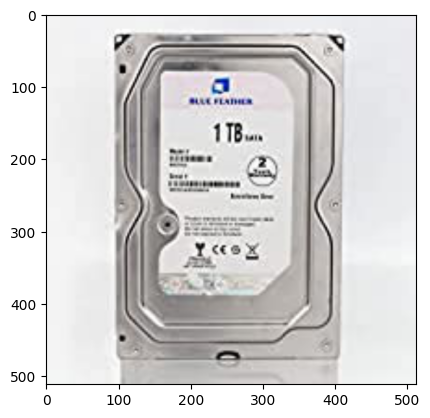

In [47]:
plt.imshow(batch_1[2])

In [11]:
test_df

,index,image_link,group_id,entity_name
0,0,https://m.media-amazon.com/images/I/110EibNycl...,156839,height
1,1,https://m.media-amazon.com/images/I/11TU2clswz...,792578,width
2,2,https://m.media-amazon.com/images/I/11TU2clswz...,792578,height
3,3,https://m.media-amazon.com/images/I/11TU2clswz...,792578,depth
4,4,https://m.media-amazon.com/images/I/11gHj8dhhr...,792578,depth
...,...,...,...,...
131182,131283,https://m.media-amazon.com/images/I/A1rVsIzEtk...,721522,maximum_weight_recommendation
131183,131284,https://m.media-amazon.com/images/I/A1rdvZ5zDd...,603688,item_weight
131184,131285,https://m.media-amazon.com/images/I/A1rdvZ5zDd...,603688,maximum_weight_recommendation
131185,131286,https://m.media-amazon.com/images/I/A1tnTUPyr7...,853009,item_weight
